<h1 align='center'>DS420: Lab 6 Spark Streaming</h1>

## Goal:

In this lab, you are hired by a financial corporate to conduct fraud detection by applying spark streaming with `File` source.

## Data:

The data you are going to used are located at the shared HDFS: `/ds420_shared/paysim`

The data simulate mobile money transactions based on a sample of real transactions extracted from one month of financial logs from a mobile money service implemented in an African country. The original logs were provided by a multinational company, who is the provider of the mobile financial service which is currently running in more than 14 countries all around the world.

## Schema:

This is a sample of 1 row with headers explanation:

`1,PAYMENT,1060.31,C429214117,1089.0,28.69,M1591654462,0.0,0.0,0,0`

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 168 (7 days simulation). 

#### Note: `Each step of data is saved onto a unique file on the shared HDFS.`

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount -
amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

In [1]:
import findspark
findspark.init('/opt/spark')

## Q1: Create a Spark session, and named it as lab6_xxx, where xxx is your last name. Note that you won't need the Kafka dependencies.

In [2]:
# Create a Spark Session

from pyspark.sql import SparkSession


# Just change the appName but don't modify the configurations!

spark = SparkSession.builder.appName('sparkStreaming_PE6_moynihan')          \
                    .config('spark.jars.packages','org.apache.spark:spark-sql-kafka-0-10_2.12:3.0.1')\
                    .config('spark.jars.packages','org.apache.kafka:kafka-clients:2.4.1')\
                    .getOrCreate()

22/05/07 14:38:04 WARN Utils: Your hostname, GPUServer resolves to a loopback address: 127.0.1.1; using 10.4.10.8 instead (on interface enp2s0)
22/05/07 14:38:04 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Ivy Default Cache set to: /home/moynihanl/.ivy2/cache
The jars for the packages stored in: /home/moynihanl/.ivy2/jars
:: loading settings :: url = jar:file:/opt/spark-3.0.1/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml
org.apache.kafka#kafka-clients added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-6e7d8860-d3ad-40c1-98f2-dc7814a97008;1.0
	confs: [default]
	found org.apache.kafka#kafka-clients;2.4.1 in central
	found com.github.luben#zstd-jni;1.4.3-1 in central
	found org.lz4#lz4-java;1.6.0 in central
	found org.xerial.snappy#snappy-java;1.1.7.3 in central
	found org.slf4j#slf4j-api;1.7.28 in central
:: resolution report :: resolve 132ms :: artifacts dl 5ms
	:: modules in use:
	com.github.luben#zstd-jn

#### List all the data files on the shared HDFS folder using `hdfs dfs` command. 

In [3]:
!/home/hadoop/hadoop-3.2.1/bin/hdfs dfs -ls /ds420_shared/paysim

Found 168 items
-rw-r--r--   1 lip ds420     174022 2020-11-05 20:41 /ds420_shared/paysim/part-00000-004e6d42-bd34-44a9-a18b-2203ab3ad05d-c000.csv
-rw-r--r--   1 lip ds420        683 2020-11-10 16:51 /ds420_shared/paysim/part-00000-0084ddfd-ec6a-423c-8c7a-ad65f92726c9-c000.csv
-rw-r--r--   1 lip ds420     315517 2020-11-10 16:51 /ds420_shared/paysim/part-00000-0135f73b-0457-4327-ae64-b9caf04b0ebe-c000.csv
-rw-r--r--   1 lip ds420    2276175 2020-11-10 16:51 /ds420_shared/paysim/part-00000-013c9a5c-b352-4e64-b968-c5640a9e27f7-c000.csv
-rw-r--r--   1 lip ds420     353752 2020-11-10 16:51 /ds420_shared/paysim/part-00000-0180a491-d70a-4194-a8ac-79b89af6c987-c000.csv
-rw-r--r--   1 lip ds420    2088278 2020-11-10 16:51 /ds420_shared/paysim/part-00000-01cbd1ec-6256-47a9-a708-0841fc253022-c000.csv
-rw-r--r--   1 lip ds420        810 2020-11-10 16:51 /ds420_shared/paysim/part-00000-02d36254-12b0-4b22-b1a1-5dc9fed1f893-c000.csv
-rw-r--r--   1 lip ds420      66847 2020-11-10 16:51 /ds420_shared/

#### Let's first try to read in ONLY the first file on the list as a non-streaming DataFrame.

In [4]:
singleFile = spark.read.csv('hdfs://localhost:9000/ds420_shared/paysim/part-00000-004e6d42-bd34-44a9-a18b-2203ab3ad05d-c000.csv',inferSchema = True, 
                      header = True)




## Q2: Study the `singleFile` DataFrame.

#### Show the top 10 rows of the DataFrame.

In [5]:
singleFile.show(10)

+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+
|step|    type|   amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|
+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+
| 429|CASH_OUT|102499.12|C1849492127|      11034.0|           0.0|C1250506130|      79834.67|     182333.79|
| 429| PAYMENT|  1780.49| C587127232|      30522.0|      28741.51| M627292834|           0.0|           0.0|
| 429| PAYMENT|  1722.22|C2140027529|       5592.0|       3869.78|M2040657437|           0.0|           0.0|
| 429| PAYMENT|  3828.73| C759496752|      39899.0|      36070.27| M365631888|           0.0|           0.0|
| 429|TRANSFER| 63129.48| C455029714|       4048.0|           0.0|C1828878126|           0.0|      63129.48|
| 429| CASH_IN|126025.28|C1844981682|      20968.0|     146993.28| C844561002|     217592.62|      91567.33|
| 429| CASH_IN| 625

#### Show the schema of the DataFrame.

In [6]:
singleFile.printSchema()

root
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)



#### Verify whether this file only contains a single `step`.

In [7]:
singleFile.groupBy('step').count().show()

+----+-----+
|step|count|
+----+-----+
| 429| 2357|
+----+-----+



#### To cheat it a little bit, let's save the schema of `singleFile` for later use.

In [8]:
dataSchema = singleFile.schema


dataSchema

StructType(List(StructField(step,IntegerType,true),StructField(type,StringType,true),StructField(amount,DoubleType,true),StructField(nameOrig,StringType,true),StructField(oldbalanceOrg,DoubleType,true),StructField(newbalanceOrig,DoubleType,true),StructField(nameDest,StringType,true),StructField(oldbalanceDest,DoubleType,true),StructField(newbalanceDest,DoubleType,true)))

## Q3: Let’s create a streaming version of this input, we'll read each file one by one as if it was a stream. 

#### Note: option `'maxFilesPerTrigger'` allows you to control how quickly Spark will read all of the files in the folder. In this example we're limiting the flow of the stream to one file per trigger. 
+ Ensure to provide the data schema as you read in the data stream. 
+ Ensure to add in a new `'timestamp'` column while reading the data in using `.withColumn()`. Consider using pyspark build-in function [current_timestamp()](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=date#pyspark.sql.functions.current_timestamp)

In [9]:
import pyspark.sql.functions as F

In [10]:
streaming = (spark.readStream.\
             schema(dataSchema)\
             .option('maxFilesPerTrigger', 1)\
             .option('includeTimeStamp','true')\
             .csv("hdfs://localhost:9000/ds420_shared/paysim")\
             .withColumn('timestamp', F.current_timestamp())

    
    
    
)

#### Verify if the DataFrame is streaming.

In [11]:
streaming.isStreaming

True

#### Print out the schema, note there is a 'timestamp' column by the end. Very nice! Looks like the data retains the correct schema. This will save us lots of time on data parsing. 

In [12]:
streaming.printSchema()

root
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- timestamp: timestamp (nullable = false)



## Q4: Let's set up a streaming query.

#### Assume that if there are many transcations ended at the same destination, then it's likely to be a fraud. Knowing the `nameDest` column is the recipient ID of the transaction, let's write a transformation to sort the `nameDest` in descending order with `nameDest`'s number of occurences. 

Note: in the last lecture, we discussed that `orderBy` cannot be easily achieved when using Kafka sources. However, we should be able to use it with file sources, as they are deterministic. 

In [13]:
from pyspark.sql.types import *

In [14]:
dest_count = streaming.groupBy('nameDest').count().orderBy('count',ascending=False)




#### Now that we have our transformation, we need to specify an output sink for the results.

+ For this example, we're going to write to a memory sink which keeps the results in memory.

+ We also need to define how Spark will output that data. In this example, we'll use the complete output mode (rewriting all of the keys along with their counts after every trigger).

+ In this example we won't include activityQuery.awaitTermination() because it is required only to prevent the driver process from terminating when the stream is active. So in order to be able to run this locally in a notebook we won't include it.

In [15]:
activityQuery = (

    dest_count.writeStream
         .outputMode('complete')
         .format('memory')
         .option('transaction','false')
         .queryName('activityQuery')
         .start()
 
    
)


22/04/27 13:06:57 WARN StreamingQueryManager: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-010e34f1-0240-413b-b3c6-21f79b8aec0c. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.


In [16]:
#activityQuery.stop()


#### Now use a loop to poll the query results from last cell. Generate 20 interations, and pause for 0.5 second for each iteration.

In [17]:
import time

for x in range(20):
    df = spark.sql('SELECT * FROM activityQuery')

    df.show(10)
    time.sleep(.5)




+--------+-----+
|nameDest|count|
+--------+-----+
+--------+-----+



+--------+-----+
|nameDest|count|
+--------+-----+
+--------+-----+



+--------+-----+
|nameDest|count|
+--------+-----+
+--------+-----+



+--------+-----+
|nameDest|count|
+--------+-----+
+--------+-----+



+-----------+-----+
|   nameDest|count|
+-----------+-----+
|C1096358251|    2|
|M1629154613|    1|
| M113229583|    1|
| C530298945|    1|
| C473286442|    1|
|M1136484117|    1|
| C207699093|    1|
| C556845837|    1|
| C115890198|    1|
|M1520465793|    1|
+-----------+-----+
only showing top 10 rows



+-----------+-----+
|   nameDest|count|
+-----------+-----+
|C1096358251|    2|
|M1629154613|    1|
| M113229583|    1|
| C530298945|    1|
| C473286442|    1|
|M1136484117|    1|
| C207699093|    1|
| C556845837|    1|
| C115890198|    1|
|M1520465793|    1|
+-----------+-----+
only showing top 10 rows



+-----------+-----+
|   nameDest|count|
+-----------+-----+
|C1096358251|    2|
|   nameDest|    2|
| C473286442|    1|
|M1136484117|    1|
|C1469065727|    1|
|M1629154613|    1|
| M113229583|    1|
| C530298945|    1|
| C207699093|    1|
|C1353252300|    1|
+-----------+-----+
only showing top 10 rows



+-----------+-----+
|   nameDest|count|
+-----------+-----+
|C1096358251|    2|
|   nameDest|    2|
| C473286442|    1|
|M1136484117|    1|
|C1469065727|    1|
|M1629154613|    1|
| M113229583|    1|
| C530298945|    1|
| C207699093|    1|
|C1353252300|    1|
+-----------+-----+
only showing top 10 rows



+-----------+-----+
|   nameDest|count|
+-----------+-----+
|   nameDest|    3|
|C1096358251|    2|
| C917200245|    2|
| C129866793|    2|
| C203170356|    2|
| C256667415|    2|
| C695944516|    2|
|C1390295291|    2|
|C1950148148|    2|
|C1791332027|    2|
+-----------+-----+
only showing top 10 rows



+-----------+-----+
|   nameDest|count|
+-----------+-----+
|   nameDest|    3|
|C1096358251|    2|
| C917200245|    2|
| C129866793|    2|
| C203170356|    2|
| C256667415|    2|
| C695944516|    2|
|C1390295291|    2|
|C1950148148|    2|
|C1791332027|    2|
+-----------+-----+
only showing top 10 rows



+-----------+-----+
|   nameDest|count|
+-----------+-----+
|   nameDest|    4|
|C1646402381|    3|
| C669865371|    3|
| C967163457|    3|
|C1469679082|    3|
|C2047987632|    3|
|C1711718999|    3|
| C523421579|    3|
|C2092899449|    3|
| C415050880|    3|
+-----------+-----+
only showing top 10 rows



+-----------+-----+
|   nameDest|count|
+-----------+-----+
|   nameDest|    4|
|C1646402381|    3|
| C669865371|    3|
| C967163457|    3|
|C1469679082|    3|
|C2047987632|    3|
|C1711718999|    3|
| C523421579|    3|
|C2092899449|    3|
| C415050880|    3|
+-----------+-----+
only showing top 10 rows

+-----------+-----+
|   nameDest|count|
+-----------+-----+
|   nameDest|    5|
| C447348916|    4|
|C1646402381|    3|
| C669865371|    3|
| C967163457|    3|
|C1469679082|    3|
|C2047987632|    3|
|C1430052429|    3|
|C1711718999|    3|
| C523421579|    3|
+-----------+-----+
only showing top 10 rows



+-----------+-----+
|   nameDest|count|
+-----------+-----+
|   nameDest|    5|
| C447348916|    4|
|C1646402381|    3|
| C669865371|    3|
| C967163457|    3|
|C1469679082|    3|
|C2047987632|    3|
|C1430052429|    3|
|C1711718999|    3|
| C523421579|    3|
+-----------+-----+
only showing top 10 rows

+-----------+-----+
|   nameDest|count|
+-----------+-----+
|   nameDest|    6|
|C1662173477|    4|
|C2089017191|    4|
| C447348916|    4|
| C128187691|    4|
|C1646402381|    3|
|C1616817673|    3|
|C1175586823|    3|
| C669865371|    3|
|C1540448538|    3|
+-----------+-----+
only showing top 10 rows



+-----------+-----+
|   nameDest|count|
+-----------+-----+
|   nameDest|    6|
|C1662173477|    4|
|C2089017191|    4|
| C447348916|    4|
| C128187691|    4|
|C1646402381|    3|
|C1616817673|    3|
|C1175586823|    3|
| C669865371|    3|
|C1540448538|    3|
+-----------+-----+
only showing top 10 rows



+-----------+-----+
|   nameDest|count|
+-----------+-----+
|   nameDest|    7|
|C1662173477|    4|
|C2089017191|    4|
| C447348916|    4|
| C128187691|    4|
|C1646402381|    3|
|C1616817673|    3|
|C1175586823|    3|
| C669865371|    3|
|C1540448538|    3|
+-----------+-----+
only showing top 10 rows



+-----------+-----+
|   nameDest|count|
+-----------+-----+
|   nameDest|    7|
|C1662173477|    4|
|C2089017191|    4|
| C447348916|    4|
| C128187691|    4|
|C1646402381|    3|
|C1616817673|    3|
|C1175586823|    3|
| C669865371|    3|
|C1540448538|    3|
+-----------+-----+
only showing top 10 rows



+-----------+-----+
|   nameDest|count|
+-----------+-----+
|   nameDest|    8|
|C1662173477|    4|
|C2089017191|    4|
| C447348916|    4|
| C128187691|    4|
|C1646402381|    3|
|C1616817673|    3|
|C1175586823|    3|
| C669865371|    3|
|C1540448538|    3|
+-----------+-----+
only showing top 10 rows



+-----------+-----+
|   nameDest|count|
+-----------+-----+
|   nameDest|    8|
|C1662173477|    4|
|C2089017191|    4|
| C447348916|    4|
| C128187691|    4|
|C1646402381|    3|
|C1616817673|    3|
|C1175586823|    3|
| C669865371|    3|
|C1540448538|    3|
+-----------+-----+
only showing top 10 rows



## Q5: Handling an active streaming query

#### Note that the results from the last cell contains a row named `nameDest`. These are missing data entries from the original dataset. Let's re-write the SQL query in the loop to exclude `nameDest` and only show the recipient IDs which appear at least `twice`. 

In [18]:
for x in range(20):
    df = spark.sql('SELECT * FROM activityQuery WHERE NOT nameDest = "nameDest" AND count>2')

    df.show(10)
    time.sleep(.5)







+-----------+-----+
|   nameDest|count|
+-----------+-----+
|C1662173477|    4|
|C2089017191|    4|
| C447348916|    4|
| C128187691|    4|
|C1646402381|    3|
|C1616817673|    3|
|C1175586823|    3|
| C669865371|    3|
|C1540448538|    3|
|C1639805485|    3|
+-----------+-----+
only showing top 10 rows



+-----------+-----+
|   nameDest|count|
+-----------+-----+
|C1662173477|    4|
|C2089017191|    4|
| C447348916|    4|
| C128187691|    4|
|C1646402381|    3|
|C1616817673|    3|
|C1175586823|    3|
| C669865371|    3|
|C1540448538|    3|
|C1639805485|    3|
+-----------+-----+
only showing top 10 rows



+-----------+-----+
|   nameDest|count|
+-----------+-----+
|C1662173477|    4|
|C2089017191|    4|
| C447348916|    4|
| C128187691|    4|
|C1646402381|    3|
|C1616817673|    3|
|C1175586823|    3|
| C669865371|    3|
|C1540448538|    3|
|C1639805485|    3|
+-----------+-----+
only showing top 10 rows



+-----------+-----+
|   nameDest|count|
+-----------+-----+
|C1662173477|    4|
|C2089017191|    4|
| C447348916|    4|
| C128187691|    4|
|C1646402381|    3|
|C1616817673|    3|
|C1175586823|    3|
| C669865371|    3|
|C1540448538|    3|
|C1639805485|    3|
+-----------+-----+
only showing top 10 rows



+-----------+-----+
|   nameDest|count|
+-----------+-----+
|C1217358061|    4|
|C1662173477|    4|
|C2089017191|    4|
| C447348916|    4|
|C1668505392|    4|
| C128187691|    4|
|C1646402381|    3|
|C1616817673|    3|
|C1175586823|    3|
| C669865371|    3|
+-----------+-----+
only showing top 10 rows

+-----------+-----+
|   nameDest|count|
+-----------+-----+
|C1217358061|    4|
|C1662173477|    4|
|C2089017191|    4|
| C447348916|    4|
|C1668505392|    4|
| C128187691|    4|
|C1646402381|    3|
|C1616817673|    3|
|C1175586823|    3|
| C669865371|    3|
+-----------+-----+
only showing top 10 rows



+-----------+-----+
|   nameDest|count|
+-----------+-----+
|C1217358061|    4|
|C1662173477|    4|
|C2089017191|    4|
| C447348916|    4|
|C1668505392|    4|
| C128187691|    4|
|C1646402381|    3|
|C1616817673|    3|
|C1175586823|    3|
| C669865371|    3|
+-----------+-----+
only showing top 10 rows



+-----------+-----+
|   nameDest|count|
+-----------+-----+
|C1217358061|    4|
|C1662173477|    4|
|C2089017191|    4|
| C447348916|    4|
|C1668505392|    4|
| C128187691|    4|
|C1646402381|    3|
|C1616817673|    3|
|C1175586823|    3|
| C669865371|    3|
+-----------+-----+
only showing top 10 rows



+-----------+-----+
|   nameDest|count|
+-----------+-----+
|C2107268831|    4|
|C1217358061|    4|
|C2047987632|    4|
|C1711718999|    4|
| C189021232|    4|
|C1662173477|    4|
| C415050880|    4|
|C2089017191|    4|
|C2033049104|    4|
| C329387723|    4|
+-----------+-----+
only showing top 10 rows



+-----------+-----+
|   nameDest|count|
+-----------+-----+
|C2107268831|    4|
|C1217358061|    4|
|C2047987632|    4|
|C1711718999|    4|
| C189021232|    4|
|C1662173477|    4|
| C415050880|    4|
|C2089017191|    4|
|C2033049104|    4|
| C329387723|    4|
+-----------+-----+
only showing top 10 rows



+-----------+-----+
|   nameDest|count|
+-----------+-----+
|C2107268831|    4|
|C1217358061|    4|
|C2047987632|    4|
|C1711718999|    4|
| C189021232|    4|
|C1662173477|    4|
| C415050880|    4|
|C2089017191|    4|
|C2033049104|    4|
| C329387723|    4|
+-----------+-----+
only showing top 10 rows



+-----------+-----+
|   nameDest|count|
+-----------+-----+
|C2107268831|    4|
|C1217358061|    4|
|C2047987632|    4|
|C1711718999|    4|
| C189021232|    4|
|C1662173477|    4|
| C415050880|    4|
|C2089017191|    4|
|C2033049104|    4|
| C329387723|    4|
+-----------+-----+
only showing top 10 rows



+-----------+-----+
|   nameDest|count|
+-----------+-----+
|C2107268831|    4|
|C1217358061|    4|
|C2047987632|    4|
|C1711718999|    4|
| C189021232|    4|
|C1662173477|    4|
| C415050880|    4|
|C2089017191|    4|
|C2033049104|    4|
| C329387723|    4|
+-----------+-----+
only showing top 10 rows



+-----------+-----+
|   nameDest|count|
+-----------+-----+
|C2107268831|    4|
|C1217358061|    4|
|C2047987632|    4|
|C1711718999|    4|
| C189021232|    4|
|C1662173477|    4|
| C415050880|    4|
|C2089017191|    4|
|C2033049104|    4|
| C329387723|    4|
+-----------+-----+
only showing top 10 rows



+-----------+-----+
|   nameDest|count|
+-----------+-----+
|C2033049104|    5|
| C944900274|    4|
|C1620683242|    4|
| C810358289|    4|
|C2107268831|    4|
|C1217358061|    4|
| C519261901|    4|
|C2047987632|    4|
|C1664952213|    4|
|C1217280492|    4|
+-----------+-----+
only showing top 10 rows



+-----------+-----+
|   nameDest|count|
+-----------+-----+
|C2033049104|    5|
| C944900274|    4|
|C1620683242|    4|
| C810358289|    4|
|C2107268831|    4|
|C1217358061|    4|
| C519261901|    4|
|C2047987632|    4|
|C1664952213|    4|
|C1217280492|    4|
+-----------+-----+
only showing top 10 rows

+-----------+-----+
|   nameDest|count|
+-----------+-----+
|C2033049104|    5|
| C944900274|    4|
|C1620683242|    4|
| C810358289|    4|
|C2107268831|    4|
|C1217358061|    4|
| C519261901|    4|
|C2047987632|    4|
|C1664952213|    4|
|C1217280492|    4|
+-----------+-----+
only showing top 10 rows



+-----------+-----+
|   nameDest|count|
+-----------+-----+
|C2033049104|    5|
| C944900274|    4|
|C1620683242|    4|
| C810358289|    4|
|C2107268831|    4|
|C1217358061|    4|
| C519261901|    4|
|C2047987632|    4|
|C1664952213|    4|
|C1217280492|    4|
+-----------+-----+
only showing top 10 rows



+-----------+-----+
|   nameDest|count|
+-----------+-----+
|C2033049104|    5|
| C944900274|    4|
|C1620683242|    4|
| C810358289|    4|
|C2107268831|    4|
|C1217358061|    4|
| C519261901|    4|
|C2047987632|    4|
|C1664952213|    4|
|C1217280492|    4|
+-----------+-----+
only showing top 10 rows



+-----------+-----+
|   nameDest|count|
+-----------+-----+
|C2033049104|    5|
| C944900274|    4|
|C1620683242|    4|
| C810358289|    4|
|C2107268831|    4|
|C1217358061|    4|
| C519261901|    4|
|C2047987632|    4|
|C1664952213|    4|
|C1217280492|    4|
+-----------+-----+
only showing top 10 rows



#### Check if stream is still active

In [19]:
streaming.isStreaming



True

#### Check the status of the `activityQuery`

In [20]:
activityQuery.status

{'message': 'Processing new data',
 'isDataAvailable': True,
 'isTriggerActive': True}

#### Let's turn off the stream.

In [22]:
activityQuery.stop()



## Q6: Write a windowed query to find the total transcation dollar amount for each payment type.

+ Show only the aggregated `'amount'` and rename it to `'TotalAmount'`. (Consider using `withColumnRenamed`).
+ Use window interval as 20 seconds, and sliding interval as 10 seconds.
+ Ensure to order the result by `'window'`

#### Write the windowed transformation.

In [23]:
from pyspark.sql.functions import window


In [24]:
streaming.printSchema()

root
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- timestamp: timestamp (nullable = false)



In [25]:
totalAmount = (streaming.groupBy('type', window('timestamp', '20 seconds', '10 seconds'))
               .sum('amount')
               .withColumnRenamed('sum(amount)', 'TotalAmount')
               .orderBy('window')
              )

In [26]:
totalAmount.printSchema()

root
 |-- type: string (nullable = true)
 |-- window: struct (nullable = true)
 |    |-- start: timestamp (nullable = true)
 |    |-- end: timestamp (nullable = true)
 |-- TotalAmount: double (nullable = true)



In [27]:
totalAmount.printSchema()

root
 |-- type: string (nullable = true)
 |-- window: struct (nullable = true)
 |    |-- start: timestamp (nullable = true)
 |    |-- end: timestamp (nullable = true)
 |-- TotalAmount: double (nullable = true)



#### Register a query and specify the output sink as memory.

In [28]:
winQuery = ( 
    

    totalAmount.writeStream
         .outputMode('complete')
         .format('memory')
         .option('transaction','false')
         .queryName('winQuery')
         .start()
    
    
    
)

22/04/27 13:07:57 WARN StreamingQueryManager: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-cbdfe015-e616-4b9f-8c9f-05f136b476f2. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.


#### Now use a loop to poll the query results from last cell. Generate 20 interations, and pause for 0.5 seconds for each iteration. 
+ Ensure to exclude 'type' type and only show the total amount if it's no less than 500,000,000

In [29]:
for x in range(20):
    df = spark.sql('SELECT * FROM winQuery WHERE NOT type = "type" AND "amount" >= 500000000')
    df.show(10)
    time.sleep(.5)







+----+------+-----------+
|type|window|TotalAmount|
+----+------+-----------+
+----+------+-----------+

+----+------+-----------+
|type|window|TotalAmount|
+----+------+-----------+
+----+------+-----------+

+----+------+-----------+
|type|window|TotalAmount|
+----+------+-----------+
+----+------+-----------+



+----+------+-----------+
|type|window|TotalAmount|
+----+------+-----------+
+----+------+-----------+



+----+------+-----------+
|type|window|TotalAmount|
+----+------+-----------+
+----+------+-----------+

+----+------+-----------+
|type|window|TotalAmount|
+----+------+-----------+
+----+------+-----------+

+----+------+-----------+
|type|window|TotalAmount|
+----+------+-----------+
+----+------+-----------+

+----+------+-----------+
|type|window|TotalAmount|
+----+------+-----------+
+----+------+-----------+

+----+------+-----------+
|type|window|TotalAmount|
+----+------+-----------+
+----+------+-----------+



+----+------+-----------+
|type|window|TotalAmount|
+----+------+-----------+
+----+------+-----------+



+----+------+-----------+
|type|window|TotalAmount|
+----+------+-----------+
+----+------+-----------+



+----+------+-----------+
|type|window|TotalAmount|
+----+------+-----------+
+----+------+-----------+

+----+------+-----------+
|type|window|TotalAmount|
+----+------+-----------+
+----+------+-----------+



+----+------+-----------+
|type|window|TotalAmount|
+----+------+-----------+
+----+------+-----------+

+----+------+-----------+
|type|window|TotalAmount|
+----+------+-----------+
+----+------+-----------+

+----+------+-----------+
|type|window|TotalAmount|
+----+------+-----------+
+----+------+-----------+

+----+------+-----------+
|type|window|TotalAmount|
+----+------+-----------+
+----+------+-----------+



+----+------+-----------+
|type|window|TotalAmount|
+----+------+-----------+
+----+------+-----------+



+----+------+-----------+
|type|window|TotalAmount|
+----+------+-----------+
+----+------+-----------+

+----+------+-----------+
|type|window|TotalAmount|
+----+------+-----------+
+----+------+-----------+



In [30]:
winQuery.stop()

22/04/27 13:08:15 WARN TaskSetManager: Lost task 44.0 in stage 235.0 (TID 15220, 10.4.10.8, executor driver): TaskKilled (Stage cancelled)
22/04/27 13:08:15 WARN Shell: Interrupted while joining on: Thread[Thread-119473,5,]
java.lang.InterruptedException
	at java.base/java.lang.Object.wait(Native Method)
	at java.base/java.lang.Thread.join(Thread.java:1300)
	at java.base/java.lang.Thread.join(Thread.java:1375)
	at org.apache.hadoop.util.Shell.joinThread(Shell.java:1043)
	at org.apache.hadoop.util.Shell.runCommand(Shell.java:1003)
	at org.apache.hadoop.util.Shell.run(Shell.java:901)
	at org.apache.hadoop.util.Shell$ShellCommandExecutor.execute(Shell.java:1213)
	at org.apache.hadoop.util.Shell.execCommand(Shell.java:1307)
	at org.apache.hadoop.util.Shell.execCommand(Shell.java:1289)
	at org.apache.hadoop.fs.RawLocalFileSystem.setPermission(RawLocalFileSystem.java:865)
	at org.apache.hadoop.fs.RawLocalFileSystem$LocalFSFileOutputStream.<init>(RawLocalFileSystem.java:252)
	at org.apache.ha

## Q7: Creating a Dashboard

#### Write a transformation to find the top `'step'`s that have the largest amount of `'newbalanceDest'`. Rename the resulting column to `'totalNewBal'`.

In [31]:
streaming.printSchema()

root
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- timestamp: timestamp (nullable = false)



In [32]:
steps = streaming.select(streaming.step, streaming.newbalanceDest)

topNewBal = (streaming.groupBy('step').agg({'newbalanceDest': 'sum'})
            .withColumnRenamed('sum(newbalanceDest)', 'totalNewBal')
    
    
    
    
)

In [33]:
topNewBal.printSchema()

root
 |-- step: integer (nullable = true)
 |-- totalNewBal: double (nullable = true)



#### Register a query and specify the output sink as memory.

In [34]:
newBalQuery = (topNewBal
               .writeStream
               .outputMode('complete')
               .format('memory')
               .option('truncate','false')
               .queryName('newBalQuery').start()

    
    
    
)

22/04/27 13:08:20 WARN StreamingQueryManager: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-cbade78c-e2ac-4258-87a0-5c5d24460124. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.


#### Import visualization libraries

In [35]:


import seaborn as sns
import matplotlib.pyplot as plt
from IPython import display


#### Graph the dashboard. 
+ Refresh the view every 5 seconds
+ Show only the top 10 steps

*Note*: at this point, it's likely that your graph may not look 'dynamic' at all, as all the data files have been streamed. You can restart the kernel and click run-all.

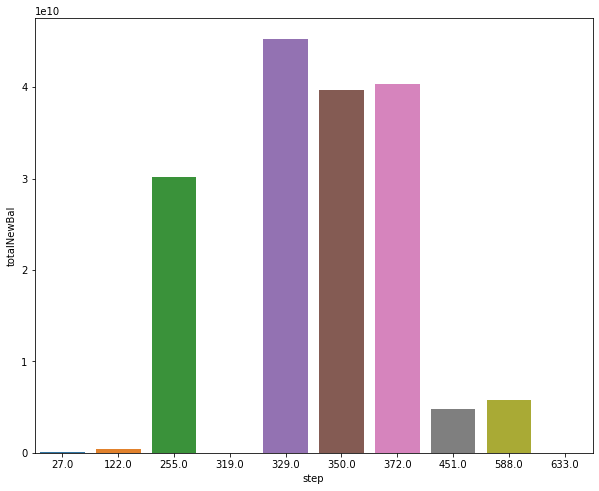

In [36]:
for i in range(10):
    time.sleep(5)
    df = spark.sql('SELECT * FROM newBalQuery')
    display.clear_output(wait=True)
    plt.figure(figsize = (10,8))
    sns.barplot(data = df_pd.head(10), x = 'step', y = "totalNewBal")
    plt.show()




    

# Great Job!